In [1]:
from transformers import AutoTokenizer
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
from time import sleep
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from datasets import load_dataset

dataset = load_dataset("frgfm/imagenette","160px")


Found cached dataset imagenette (/Users/pauladler/.cache/huggingface/datasets/frgfm___imagenette/160px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
jitter = Compose([ 
    ToTensor(),
    Resize((160,160))
    ])

In [4]:
def transforms(examples):

    examples["pixel_values"] = [jitter(image.convert("RGB")) for image in examples["image"]]

    return examples

In [5]:
dataset = dataset.with_transform(transforms)

In [6]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device = torch.device(device)

# Set hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [7]:
def collate_fn(examples):
    images, labels = [], []

    for example in examples:
        images.append((example["pixel_values"]))
        labels.append(example["label"])

    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "label": labels}

train_dataloader = DataLoader(dataset["train"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
val_dataloader =  DataLoader(dataset["validation"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)


In [8]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [9]:
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
tr = model.train()

In [11]:
train_accu = []
train_losses = []

def train(epoch,data):
    print('\nEpoch : %d'%epoch)
    correct = 0
    running_loss=0
    total=0
    for element in tqdm(data):
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss=running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [12]:
eval_losses=[]
eval_accu=[]

def val(data):
    correct = 0
    running_loss=0
    total=0
    with torch.no_grad():
      for element in tqdm(data):
          # Move input and label tensors to the device
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss=running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))


In [13]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1


  0%|          | 0/148 [00:00<?, ?it/s]/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 148/148 [01:44<00:00,  1.41it/s]


Train Loss: 0.649 | Accuracy: 84.423


100%|██████████| 62/62 [00:15<00:00,  3.96it/s]


Val Loss: 0.306 | Accuracy: 91.159

Epoch : 2


100%|██████████| 148/148 [01:44<00:00,  1.42it/s]


Train Loss: 0.175 | Accuracy: 94.551


100%|██████████| 62/62 [00:15<00:00,  3.94it/s]


Val Loss: 0.279 | Accuracy: 91.363

Epoch : 3


100%|██████████| 148/148 [01:43<00:00,  1.43it/s]


Train Loss: 0.113 | Accuracy: 96.304


100%|██████████| 62/62 [00:15<00:00,  3.98it/s]


Val Loss: 0.289 | Accuracy: 91.185

Epoch : 4


100%|██████████| 148/148 [01:44<00:00,  1.42it/s]


Train Loss: 0.095 | Accuracy: 97.064


100%|██████████| 62/62 [00:15<00:00,  3.98it/s]


Val Loss: 0.299 | Accuracy: 91.006

Epoch : 5


100%|██████████| 148/148 [01:43<00:00,  1.43it/s]


Train Loss: 0.084 | Accuracy: 97.518


100%|██████████| 62/62 [00:15<00:00,  3.96it/s]


Val Loss: 0.344 | Accuracy: 90.242

Epoch : 6


100%|██████████| 148/148 [01:43<00:00,  1.42it/s]


Train Loss: 0.079 | Accuracy: 97.487


100%|██████████| 62/62 [00:15<00:00,  4.00it/s]


Val Loss: 0.343 | Accuracy: 89.834

Epoch : 7


100%|██████████| 148/148 [01:43<00:00,  1.43it/s]


Train Loss: 0.080 | Accuracy: 97.487


100%|██████████| 62/62 [00:15<00:00,  3.97it/s]


Val Loss: 0.353 | Accuracy: 90.701

Epoch : 8


100%|██████████| 148/148 [01:43<00:00,  1.43it/s]


Train Loss: 0.065 | Accuracy: 97.751


100%|██████████| 62/62 [00:15<00:00,  4.07it/s]


Val Loss: 0.410 | Accuracy: 88.968

Epoch : 9


100%|██████████| 148/148 [01:42<00:00,  1.45it/s]


Train Loss: 0.052 | Accuracy: 98.384


100%|██████████| 62/62 [06:25<00:00,  6.22s/it] 


Val Loss: 0.320 | Accuracy: 91.822

Epoch : 10


100%|██████████| 148/148 [05:34<00:00,  2.26s/it]


Train Loss: 0.032 | Accuracy: 99.134


100%|██████████| 62/62 [00:15<00:00,  4.06it/s]

Val Loss: 0.376 | Accuracy: 89.911


In [14]:
import matplotlib.pyplot as plt

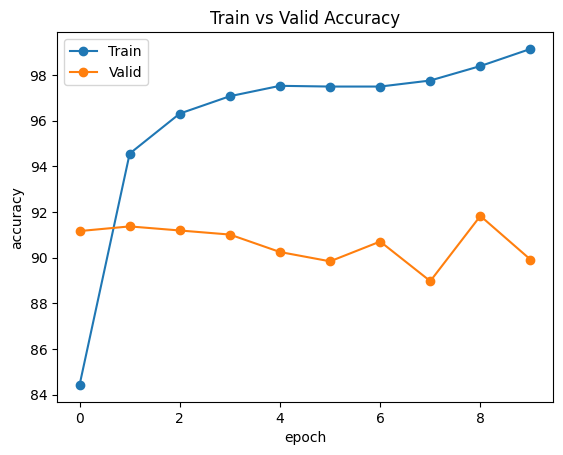

In [15]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

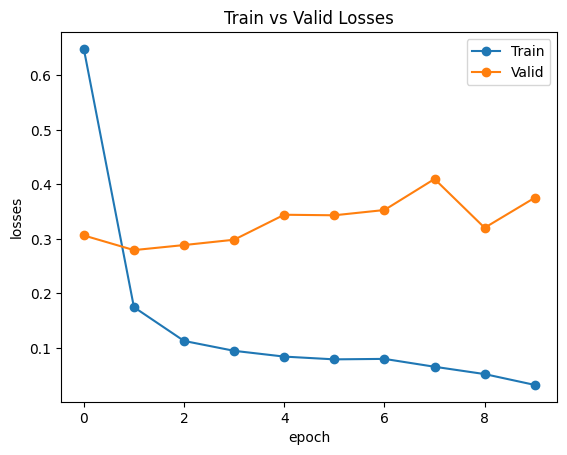

In [16]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [17]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1


  0%|          | 0/148 [00:00<?, ?it/s]/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 148/148 [01:42<00:00,  1.45it/s]


Train Loss: 0.039 | Accuracy: 98.881


100%|██████████| 62/62 [00:15<00:00,  4.12it/s]


Val Loss: 0.330 | Accuracy: 91.592

Epoch : 2


100%|██████████| 148/148 [01:41<00:00,  1.45it/s]


Train Loss: 0.029 | Accuracy: 99.145


100%|██████████| 62/62 [00:15<00:00,  4.10it/s]


Val Loss: 0.355 | Accuracy: 90.650

Epoch : 3


100%|██████████| 148/148 [01:42<00:00,  1.45it/s]


Train Loss: 0.085 | Accuracy: 97.381


100%|██████████| 62/62 [00:15<00:00,  4.09it/s]


Val Loss: 0.334 | Accuracy: 90.803

Epoch : 4


100%|██████████| 148/148 [01:41<00:00,  1.45it/s]


Train Loss: 0.051 | Accuracy: 98.395


100%|██████████| 62/62 [00:14<00:00,  4.14it/s]


Val Loss: 0.356 | Accuracy: 90.420

Epoch : 5


100%|██████████| 148/148 [01:42<00:00,  1.45it/s]


Train Loss: 0.032 | Accuracy: 98.881


100%|██████████| 62/62 [00:15<00:00,  4.11it/s]


Val Loss: 0.348 | Accuracy: 91.439

Epoch : 6


100%|██████████| 148/148 [01:41<00:00,  1.45it/s]


Train Loss: 0.027 | Accuracy: 99.071


100%|██████████| 62/62 [00:15<00:00,  4.11it/s]


Val Loss: 0.360 | Accuracy: 91.185

Epoch : 7


100%|██████████| 148/148 [01:42<00:00,  1.45it/s]


Train Loss: 0.026 | Accuracy: 99.166


100%|██████████| 62/62 [00:15<00:00,  4.10it/s]


Val Loss: 0.325 | Accuracy: 91.949

Epoch : 8


100%|██████████| 148/148 [01:42<00:00,  1.45it/s]


Train Loss: 0.047 | Accuracy: 98.437


100%|██████████| 62/62 [00:15<00:00,  4.10it/s]


Val Loss: 0.367 | Accuracy: 90.446

Epoch : 9


100%|██████████| 148/148 [01:42<00:00,  1.45it/s]


Train Loss: 0.034 | Accuracy: 98.902


100%|██████████| 62/62 [00:15<00:00,  4.11it/s]


Val Loss: 0.365 | Accuracy: 91.083

Epoch : 10


100%|██████████| 148/148 [01:41<00:00,  1.45it/s]


Train Loss: 0.026 | Accuracy: 99.176


100%|██████████| 62/62 [00:15<00:00,  4.11it/s]

Val Loss: 0.326 | Accuracy: 91.057


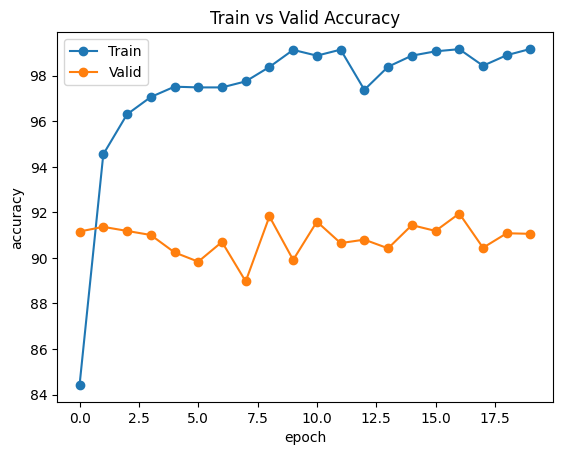

In [18]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

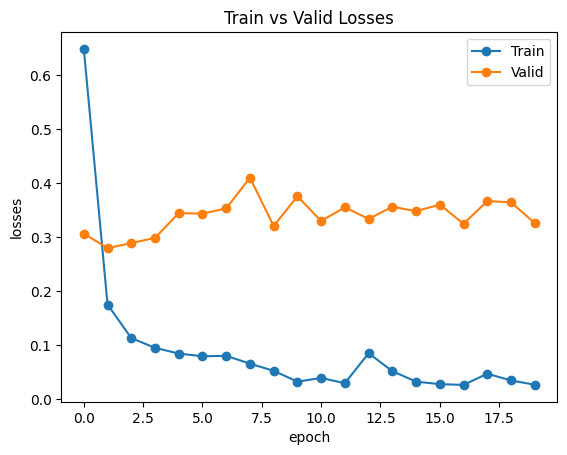

In [19]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [20]:
from torchvision.io import read_image

img = read_image("test/assets/encode_jpeg/grace_hopper_517x606.jpg")

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

RuntimeError: [Errno 2] No such file or directory: 'test/assets/encode_jpeg/grace_hopper_517x606.jpg'

In [ ]:
from PIL import Image

model.eval()
image = Image.open('test.jpg')
  
# Define a transform to convert PIL 
# image to a Torch tensor
transform = Compose([
    ToTensor()
])
  
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor

img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    
    print(predicted)

In [ ]:
dataset["train"].features["label"].names[predicted]